# Resources
Pytorch tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import time
import pygame
import seaborn as sns
from collections import deque, namedtuple
import random
from torch import nn
from torch.nn import functional as F
import torch
import math
from itertools import count
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### CartPole environment

In [3]:
# env = gym.make('CartPole-v1', render_mode = 'human')

# #Action
# #0: move left
# #1: move right

# #Observation       
# #Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity 

# #Goal: is to keep the pole upright as long as possible. There's a no terminal state for CartPole

# #Rewards
# #+1 for every step the pole is upright position
# obs = env.reset()
# MAX_TIMESTEP = 1000
# timestep = 0
# terminated = False
# history = []

# while timestep < MAX_TIMESTEP and not terminated:
#     random_action = env.action_space.sample()
#     obs, reward, terminated, truncated, info = env.step(random_action)
#     env.render()
#     timestep += 1
#     history.append(reward)

# env.close()
# pygame.quit()

### Replay Memory


stores the (s,a,r,s') values into a deque with a fixed length (drop furthest element when capacity is reached)
Why?

- breaking correlated sequential data. E.g: actions take earlier will greatly influence the current actions, result in biased learning
- By randomly sampling transitions from this memory during training, the agent learns from a diverse and uncorrelated dataset. 
- allows the agent to revisit and learn from past experiences multiple times. This is particularly beneficial when dealing with sparse rewards, where rewards might be infrequent or delayed.

In [4]:
Tuple = namedtuple("Tuple", ('x', 'y', 'z'))
a = Tuple(1,2,3)
print(a)

Tuple(x=1, y=2, z=3)


In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity) -> None:
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        '''
        @params
            batch_size: int, sample transition memory with batch_size length, 
        @returns
            memory: [Transition], list of Transition objects. return None if batch_size > len(memory) 

        '''
        if batch_size > len(self.memory):
            return None
        return random.sample(self.memory, batch_size)
    
    def clear(self):
        self.memory.clear()
    
    def __len__(self):
        return len(self.memory)

#test it
rep_mem = ReplayMemory(capacity=10)

rep_mem.push('s1', 'action 1', 's2', 35)

print('memory len = ', len(rep_mem))
print(rep_mem.sample(12))


memory len =  1
None


# DQN

### Objective
train a policy that tries to maximize the discounted, cumulative reward

### Gamma, discounted factor
lower γ makes rewards from the uncertain far future less important for our agent than the ones in the near future that it can be fairly confident about.

### minimize the TD equation using Huber Loss. 
The Huber loss acts like the mean squared error when the error is small, but like the mean absolute error when the error is large - this makes it more robust to outliers when the estimates of Q are very noisy.

In [6]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        #what's the purpose of this?
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128,n_actions)
    
    def forward(self, X):
        X = F.relu(self.layer1(X))
        X = F.relu(self.layer2(X))
        return self.layer3(X)

In [7]:
dqn = DQN(4, 4)
X = torch.rand(4,4)

y = dqn(X)
print("y shape = ", y.shape)

y shape =  torch.Size([4, 4])


In [8]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
steps_done = 0

env = gym.make('CartPole-v1', render_mode = 'human')
obs = env.reset()
n_observations = len(obs)
n_actions = env.action_space.n

policy_net = DQN(n_observations=n_observations, n_actions= n_actions).to(DEVICE)
target_net = DQN(n_observations=n_observations, n_actions= n_actions).to(DEVICE)

optimizer = torch.optim.AdamW(policy_net.parameters(), lr = LR, amsgrad=True)

memory =  ReplayMemory(10000)

In [9]:
def select_action(state):
    global steps_done

    sample = random.random()

    #controlled by EPS_DECAY constant
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)

    steps_done += 1

    #exploit
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1)
    #explore
    else:
        return torch.tensor([[env.action_space.sample()]], device = DEVICE, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [10]:
#Optimization
def optimize_model(memory, policy_net, target_net, \
    batch_size, gamma, \
    optim, criterion, 
    device, debug = False):

    #memoyr doesn't have enought transitions. Can't optimize yet
    if len(memory) < batch_size: return

    transitions = memory.sample(batch_size)
    #this converts an array of transitions into transitions of action array, state arrays, ... 
    #Transition(state = (1,2,3...), action=(4,5,6,...), next_state=(7,8,9,...))
    batch = Transition(*zip(*transitions))

    #NOTE: Make a mask of non-final states. If non-final: True, if final state: False
    #return a tensor of ([True, True, ..., False, True,...])
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device = device)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    if debug:
        print(transitions[0])
        print(transitions[1])
        print('transition len = ', len(transitions))
        print()
        print('non final next state len = ', len(non_final_next_states))
        print(non_final_next_states[:10])

    #get state_batch, action_batch, reward_batch, 
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    #Select actions that would've been taken by the model
    #gather values along dim = 1
    #the model returns (128,4), gather dim = 1, choose action index from action batch
    #state action value shape = (batch_size, 1)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    if debug:
        print('non final mask shape = ', non_final_mask.shape)
        print('non final next states shape = ', non_final_next_states.shape)
        print('state batch shape = ', state_batch.shape)
        print('action batch shape = ', action_batch.shape)
        print('reward state batch shape = ', reward_batch.shape)
        print()
        print('state action values shape = ', state_action_values.shape)

    #we want to mask the terminal states to 0s
    next_state_values = torch.zeros(batch_size, device = device)
    with torch.no_grad():
        target_net_output = target_net(non_final_next_states)
        #the target_net_output has shape (X, 4) where X may < batch_size
        #the non_final_mask is broadcast index with True, False,... where there are X True rows
        #update next_state_values with broadcast index can be done with above condition
        next_state_values[non_final_mask] = target_net_output.max(1).values
    
    #Bellman's equation
    #expected_state_action values shape = (batch_size, batch_size)
    expected_state_action_values = (next_state_values * gamma) + reward_batch
    #TODO: why expected_state_action_values shape = (128,128) and state_action_values shape = (128,1) ?? 
    if debug:
        print('expected state actions values shape = ', expected_state_action_values.shape)

    #Compute Huber Loss
    #expected state action values = (batch_size, batch_size)
    loss =criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optim.zero_grad()
    loss.backward()
    #Inplace gradient clipping
    #gradient clipping prevent explode gradient during backprop
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optim.step()

In [11]:
# a = torch.rand(10, 1)
# print(a.shape)
# print(a)

# b = torch.rand(10)
# print(b.shape)
# print(b)

# c = a + b
# print(c.shape)
# print(c)



In [12]:
# a = torch.rand(5,4)
# print(a)
# b = torch.randint(0,3, (5,1))
# print(b)
# print(a.gather(1, b))

In [13]:
# a = torch.zeros(5,4)

# b = torch.tensor([False, True, True, False, False])
# print(b.shape)

# a[b] = torch.rand(3,4)

# print(a)

In [14]:
# def optimize_model(memory, policy_net, target_net, \
#     batch_size, gamma, \
#     optim, criterion, 
#     device, debug = False):

#     if len(memory) < BATCH_SIZE:
#         return
#     transitions = memory.sample(BATCH_SIZE)
#     # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
#     # detailed explanation). This converts batch-array of Transitions
#     # to Transition of batch-arrays.
#     batch = Transition(*zip(*transitions))

#     # Compute a mask of non-final states and concatenate the batch elements
#     # (a final state would've been the one after which simulation ended)
#     non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                           batch.next_state)), device=device, dtype=torch.bool)
#     non_final_next_states = torch.cat([s for s in batch.next_state
#                                                 if s is not None])
#     state_batch = torch.cat(batch.state)
#     action_batch = torch.cat(batch.action)
#     reward_batch = torch.cat(batch.reward)

#     # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
#     # columns of actions taken. These are the actions which would've been taken
#     # for each batch state according to policy_net
#     state_action_values = policy_net(state_batch).gather(1, action_batch)

#     # Compute V(s_{t+1}) for all next states.
#     # Expected values of actions for non_final_next_states are computed based
#     # on the "older" target_net; selecting their best reward with max(1).values
#     # This is merged based on the mask, such that we'll have either the expected
#     # state value or 0 in case the state was final.
#     next_state_values = torch.zeros(BATCH_SIZE, device=device)
#     with torch.no_grad():
#         next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
#     # Compute the expected Q values
#     expected_state_action_values = (next_state_values * GAMMA) + reward_batch
#     # print('expected_state_action_values = ', expected_state_action_values.shape)
#     # print('state_action_values = ', state_action_values.shape)

#     # Compute Huber loss
#     criterion = nn.SmoothL1Loss()
#     loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

#     # Optimize the model
#     optimizer.zero_grad()
#     loss.backward()
#     # In-place gradient clipping
#     torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
#     optimizer.step()

In [30]:
#test optimze model function
policy_net = DQN(4,4).to(DEVICE)
target_net = DQN(4,4).to(DEVICE)
#copy state dict of policy net to target net
target_net.load_state_dict(policy_net.state_dict())

#test
memory = ReplayMemory(capacity = 10000)
memory.clear()

for _ in range(1000):
    #shape = (1, 4)
    state = torch.tensor([random.randint(0,3) for _ in range(4)], dtype = torch.float32).unsqueeze(0)
    #shape = (1,1)
    action = torch.tensor([random.randint(0,3)]).unsqueeze(0)
    #shape = (1, 4)
    if random.random() > 0.5:
        next_state = torch.tensor([random.randint(0,3) for _ in range(4)], dtype = torch.float32).unsqueeze(0)
    else:
        next_state = None
    #shape = (1,1)
    reward = torch.tensor([random.randint(0,3)], dtype = torch.float32).unsqueeze(0)
    memory.push(state, action, next_state, reward)

optim = torch.optim.Adam(policy_net.parameters(), lr = LR, amsgrad = True)
criterion = nn.SmoothL1Loss()

optimize_model(memory, policy_net, target_net, BATCH_SIZE, GAMMA, device = DEVICE, optim=optim, criterion=criterion, debug = True)

Transition(state=tensor([[3., 3., 3., 1.]]), action=tensor([[0]]), next_state=tensor([[0., 2., 0., 2.]]), reward=tensor([[1.]]))
Transition(state=tensor([[1., 3., 1., 3.]]), action=tensor([[2]]), next_state=tensor([[0., 1., 1., 0.]]), reward=tensor([[2.]]))
transition len =  128

non final next state len =  72
tensor([[0., 2., 0., 2.],
        [0., 1., 1., 0.],
        [1., 1., 1., 2.],
        [3., 1., 0., 3.],
        [0., 2., 0., 3.],
        [2., 2., 1., 2.],
        [2., 2., 1., 2.],
        [2., 3., 3., 1.],
        [3., 1., 1., 0.],
        [3., 0., 1., 0.]])
non final mask shape =  torch.Size([128])
non final next states shape =  torch.Size([72, 4])
state batch shape =  torch.Size([128, 4])
action batch shape =  torch.Size([128, 1])
reward state batch shape =  torch.Size([128, 1])

state action values shape =  torch.Size([128, 1])
expected state actions values shape =  torch.Size([128, 128])


/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([128, 1, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


In [16]:
env = gym.make('CartPole-v1', render_mode = 'human')

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

#why use policy net?
policy_net = DQN(n_observations, n_actions).to(DEVICE)
#why use target net?
target_net = DQN(n_observations, n_actions).to(DEVICE)

#copy policy net weights into target net
target_net.load_state_dict(policy_net.state_dict())

optimzer = torch.optim.Adam(policy_net.parameters(), lr = LR, amsgrad = True)
memory = ReplayMemory(capacity = 10000)

steps_done = 0

# Training loop

In [17]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

In [18]:
def select_action(state, epsilon):
    #state shape = (1)
    sample = random.random()

    #exploit
    if sample > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1,1)
    #explore
    else:
        return torch.tensor([[env.action_space.sample()]], device = DEVICE, dtype=torch.long)

def calculate_epsilon(step, epsilon_start , epsilon_end, epsilon_decay):
    #controlled by EPS_DECAY constant
    return epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1.0 * step / epsilon_decay)

In [29]:
a = torch.rand(1,4)
b = a.max(1)
print(b)
print(b.indices.view(1,1))

torch.return_types.max(
values=tensor([0.9506]),
indices=tensor([1]))
tensor([[1]])


In [43]:
def tune(BATCH_SIZE, GAMMA, EPS_START, EPS_END, EPS_DECAY, TAU, LR, NUM_EPISODES = 10, UPDATE_STEP = 10):
    env = gym.make('CartPole-v1', render_mode = 'human')

    n_actions = env.action_space.n
    state, info = env.reset()
    n_observations = len(state)

    #why use policy net?
    policy_net = DQN(n_observations, n_actions).to(DEVICE)
    #why use target net?
    target_net = DQN(n_observations, n_actions).to(DEVICE)

    #copy policy net weights into target net
    target_net.load_state_dict(policy_net.state_dict())

    optimzer = torch.optim.Adam(policy_net.parameters(), lr = LR, amsgrad = True)
    memory = ReplayMemory(capacity = 10000)

    steps_done = 0

    loop = tqdm(range(NUM_EPISODES))

    history = defaultdict(list)
    epsilon_decay = []
    step_count = 0

    for e in loop:
        
        state, info = env.reset()
        state = torch.tensor(state, dtype = torch.float32, device = DEVICE).unsqueeze(0)
        total_reward = 0

        for t in count():
            epsilon = calculate_epsilon(step_count, EPS_START, EPS_END, EPS_DECAY)
            step_count += 1
            epsilon_decay.append(epsilon)
            action = select_action(state, epsilon)
            obs, reward, terminated, truncated, _ = env.step(action.item())

            reward = torch.tensor([reward])
            done = terminated or truncated
            total_reward += reward.item()

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(obs, dtype = torch.float32, device = DEVICE).unsqueeze(0)
            
            memory.push(state, action, next_state, reward)

            state = next_state

            optimize_model(memory, policy_net, target_net, 128, GAMMA, optimzer, criterion, DEVICE, debug = False)

            #update state dict to policy dict every 10 timestep
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()

            if t % 10 == 0:
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key]*(1 - TAU)
                target_net.load_state_dict(target_net_state_dict)

            if done:
                break
        
            loop.set_description(f'training ep = {e}, epsilone = {epsilon}, reward = {total_reward}')
        history['reward'].append(total_reward)

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))), ax = ax1, color='red')
    ax1.set_title("Reward per episodes")
    sns.lineplot(y = epsilon_decay, x = list(range(len(epsilon_decay))), ax = ax2)
    ax2.set_title("Epsilone decay")
    plt.show()

    return history

In [1]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100000
TAU = 0.005
LR = 1e-4
NUM_EPISODES =1000
tune(BATCH_SIZE, GAMMA, EPS_START, EPS_END, EPS_DECAY, TAU, LR, NUM_EPISODES=NUM_EPISODES)

NameError: name 'tune' is not defined

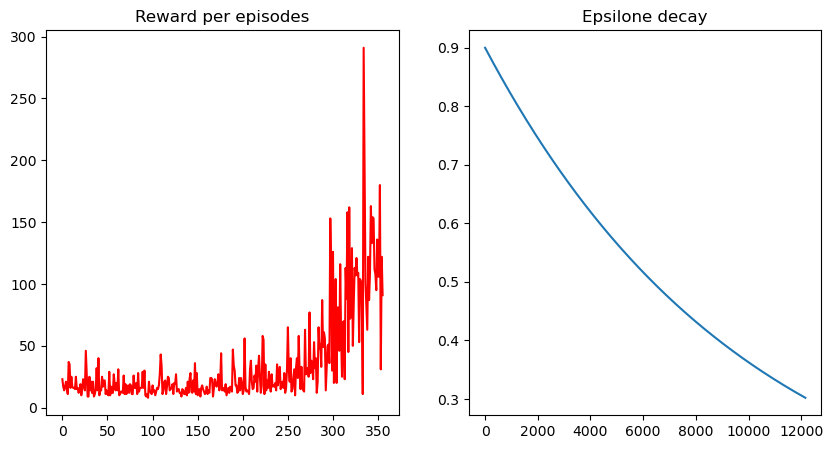

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))), ax = ax1, color='red')
ax1.set_title("Reward per episodes")
sns.lineplot(y = epsilon_decay, x = list(range(len(epsilon_decay))), ax = ax2)
ax2.set_title("Epsilone decay")
plt.show()



### Apply DQN on 3 other different environments:

1. Mountain Car
2. Snake Game
3. Breakout